In [1]:
%load_ext autoreload
import sys
import gc
import re
import numpy as np 
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pickle
#from utilities.branch_analysis_w_chain import *
from utilities.processing import *
import os

dat_list = []
path = r'C:\Users\ecsadmin\Desktop\MIST_DAT\Ratio_'
for file in os.listdir(path):
    if '.pkl' in file:
        file = os.path.join(path, file)
        with open(file, "rb") as f:
            dat_temp = pickle.load(f)
            dat_list.append(dat_temp)

#filename = r"C:\Users\ecsadmin\Downloads\prod_0p5000_0 1.pkl"
#with open(filename, "rb") as f:
#    dat0 = pickle.load(f)

#filename = r"C:\Users\ecsadmin\Downloads\prod_0p5000_1 1.pkl"
#with open(filename, "rb") as f:
#    dat1 = pickle.load(f)

In [3]:
# Get all q0 files (or q1, whichever you want)
files_0 = [f for f in os.listdir(path) if f.endswith('_0.pkl')]
# Extract EJ*EC value from filename and sort
def get_param(fname):
  match = re.search(r'ratio_(.+)_[01]\.pkl', fname)
  return float(match.group(1).replace('p', '.'))

files_0.sort(key=get_param)
param_values = [get_param(f) for f in files_0]

# Load in sorted order
dat_list_0 = []
for f in files_0:
  with open(os.path.join(path, f), 'rb') as fh:
      dat_list_0.append(pickle.load(fh))

In [4]:
# Get all q0 files (or q1, whichever you want)
files_1 = [f for f in os.listdir(path) if f.endswith('_1.pkl')]

# Extract EJ*EC value from filename and sort
def get_param(fname):
  match = re.search(r'ratio_(.+)_[01]\.pkl', fname)
  return float(match.group(1).replace('p', '.'))

files_1.sort(key=get_param)
param_values = [get_param(f) for f in files_1]

# Load in sorted order
dat_list_1 = []
for f in files_1:
  with open(os.path.join(path, f), 'rb') as fh:
      dat_list_1.append(pickle.load(fh))

In [6]:
def get_exp(curve1, curve2):
    dx = curve2[0] - curve1[0]
    dy = curve2[1] - curve1[1]
    dist = np.sqrt(dx**2 + dy**2)
    r = np.arange(len(dist))
    mask = dist > 0

    return np.polyfit(r[mask], np.log(dist[mask]), 1)[0]

def get_exp_in_flux(data, key):
    key2 = key.replace('_q', '_c')
    xdat = data[key]
    ydat = data[key2]
    num_flux = xdat.shape[0]
    lambdas = []

    for i in range(num_flux-1):
        traj0 = (x[i],   y[i])
        traj1 = (x[i+1], y[i+1])

        lambdas.append(get_exp(traj0, traj1))
    
    return lambdas

def get_exp_2D(dat_list, key):
    extent = [0, .5, 0, 39]
    key2 = key.replace('_q', '_c')
    flux_list = [len(dat[key]) for dat in dat_list]
    num_param = len(dat_list)
    num_flux = np.min(flux_list)
    exp_dat = np.zeros((num_param, num_flux-1))

    for j in range(num_param):
        x = dat_list[j][key]
        y = dat_list[j][key2]

        for i in range(num_flux-1):
            traj0 = (x[i],   y[i])
            traj1 = (x[i+1], y[i+1])

            exp_dat[j, i] = get_exp(traj0, traj1)
    return exp_dat

In [7]:
exp_dat = get_exp_2D(dat_list_0, 'n_q_branch=q0_c2')

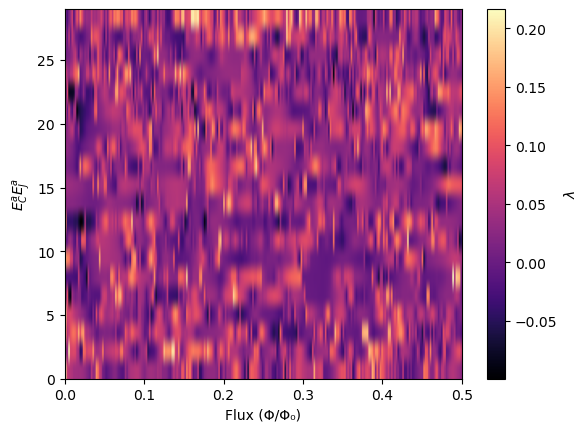

In [8]:
fig, ax = plt.subplots()
extent = [0, .5, 0, 29]
plt.imshow(exp_dat, extent = extent, cmap='magma')
ax.set_xlabel('Flux (Φ/Φ₀)')
ax.set_ylabel(r'$E_C^a E_J^a$')
ax.set_aspect('auto')
plt.colorbar(label='$\lambda$')

In [11]:
#plot_trajectories(dat0, 'n_q_branch=q0_c0', 'n_c_branch=q0_c0', init_val=0)
#plot_trajectories(dat1, 'n_q_branch=q1_c0', 'n_c_branch=q1_c0', init_val=1)

In [12]:
def get_scatter(dat_list):
    n_q_array = dat_list[0]['n_q_branch=q0_c0']
    n_c_array = dat_list[0]['n_c_branch=q0_c0']
    n_r_array = dat_list[0]['n_r_branch=q0_c0']
    flux_vals = np.linspace(0, .5, 250)
    
    n_r_steps = np.arange(0, 30, 1)
    
    for n_r_idx in n_r_steps:
        n_q_slice = n_q_array[:, n_r_idx]  # all 250 flux points at this n_r
        n_c_slice = n_c_array[:, n_r_idx]  # all 250 flux points at this n_r
        plt.scatter(n_q_slice, n_c_slice, c=flux_vals, cmap='viridis')
        plt.title(f'n_r = {n_r_idx}')
        plt.xlabel(r'$\langle n_q \rangle$')
        plt.ylabel(r'$\langle n_c \rangle$')
        plt.colorbar(label=r'$\Phi / \Phi_0$')
        plt.xlim(0, 20)
        plt.ylim(0, 5)
        plt.show()

ValueError: unknown file extension: .gif_ratio

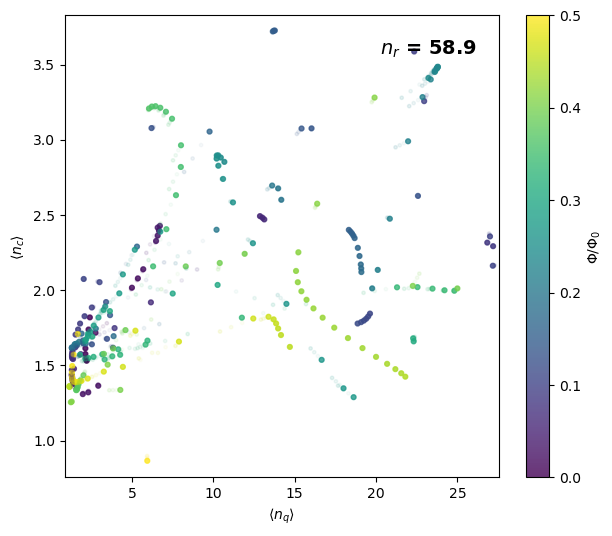

In [20]:
import numpy as np
import matplotlib.pyplot as plt                                                                                                                              
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize 

for dat, name in zip(dat_list_1, files_1):
    # Data setup
    name_fixed = name.replace('.pkl', '.gif')
    n_q = dat['n_q_branch=q1_c0']  # (250, 40)
    n_c = dat['n_c_branch=q1_c0']  # (250, 40)
    flux = np.linspace(0, 0.5, n_q.shape[0])
    
    # Interpolation: insert N_INTERP frames between each actual n_r step
    N_INTERP = 8  # smoothness — more = smoother but slower
    n_r_steps = n_q.shape[1]
    total_frames = (n_r_steps - 1) * N_INTERP
    
    def get_frame(frame_idx):
      """Interpolate positions between actual n_r steps."""
      real_idx = frame_idx / N_INTERP  # continuous index into n_r axis
      lo = int(np.floor(real_idx))
      hi = min(lo + 1, n_r_steps - 1)
      t = real_idx - lo  # interpolation parameter [0, 1]
    
      nq = n_q[:, lo] * (1 - t) + n_q[:, hi] * t
      nc = n_c[:, lo] * (1 - t) + n_c[:, hi] * t
      return nq, nc, real_idx
    
    # Fixed axes from global extent
    pad = 0.1
    nq_min, nq_max = n_q.min() - pad, n_q.max() + pad
    nc_min, nc_max = n_c.min() - pad, n_c.max() + pad
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(7, 6))
    norm = Normalize(vmin=flux.min(), vmax=flux.max())
    scat = ax.scatter([], [], c=[], cmap='viridis', norm=norm, s=12, alpha=0.8)
    ax.set_xlim(nq_min, nq_max)
    ax.set_ylim(nc_min, nc_max)
    ax.set_xlabel(r'$\langle n_q \rangle$')
    ax.set_ylabel(r'$\langle n_c \rangle$')
    nr_text = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                    ha='right', va='top', fontsize=14, fontweight='bold')
    cbar = fig.colorbar(scat, label=r'$\Phi / \Phi_0$')
    
    # Optional: trails — keep last TRAIL_LEN positions with fading alpha
    TRAIL_LEN = 4
    trails = []
    for i in range(TRAIL_LEN):
      alpha = 0.15 * (TRAIL_LEN - i) / TRAIL_LEN
      trail = ax.scatter([], [], c=[], cmap='viridis', norm=norm,
                         s=6, alpha=alpha)
      trails.append(trail)
    
    history = []
    
    def update(frame_idx):
      nq, nc, real_nr = get_frame(frame_idx)
    
      # Update main scatter
      scat.set_offsets(np.column_stack([nq, nc]))
      scat.set_array(flux)
      nr_text.set_text(f'$n_r$ = {real_nr:.1f}')
    
      # Update trails
      history.append(np.column_stack([nq, nc]))
      if len(history) > TRAIL_LEN:
          history.pop(0)
      for i, trail in enumerate(trails):
          idx = len(history) - 1 - (TRAIL_LEN - i)
          if idx >= 0:
              trail.set_offsets(history[idx])
              trail.set_array(flux)
          else:
              trail.set_offsets(np.empty((0, 2)))
    
      return [scat, nr_text] + trails
    
    anim = FuncAnimation(fig, update, frames=total_frames,
                       interval=40, blit=True)  # 40ms = 25fps
    
    anim.save(f'{name_fixed}_ratio', writer='pillow', dpi=150)
    plt.close()

In [9]:
key_list0 = ['n_q_branch=q0_c0', 'n_q_branch=q0_c1', 'n_q_branch=q0_c2', 'n_q_branch=q0_c3']
name_list0 = [r'$⟨n_c⟩ = 0$', r'$⟨n_c⟩ = 1$', r'$⟨n_c⟩ = 2$', r'$⟨n_c⟩ = 3$']
key_list1 = ['n_q_branch=q1_c0', 'n_q_branch=q1_c1', 'n_q_branch=q1_c2', 'n_q_branch=q1_c3']

NameError: name 'dat0' is not defined

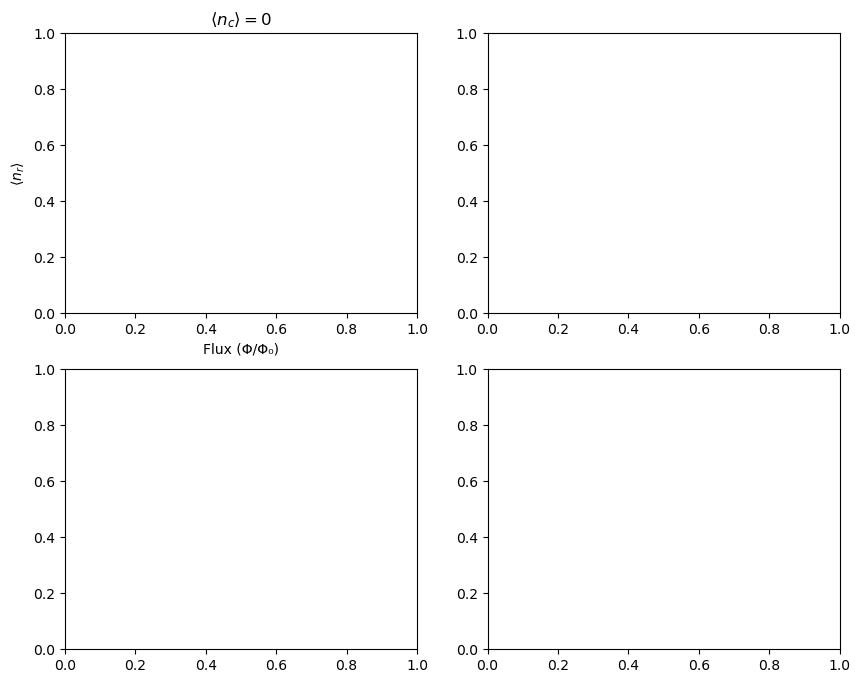

In [10]:
step =.02
flux_arr = np.arange(0, .5, step)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 80, 1)
extent = [0, .5, 0, 39]

for ax, key, name in zip(axes, key_list0, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(dat0[key].T)

    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=2)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |0⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.savefig(r'debug_1.png')
plt.show()

NameError: name 'dat1' is not defined

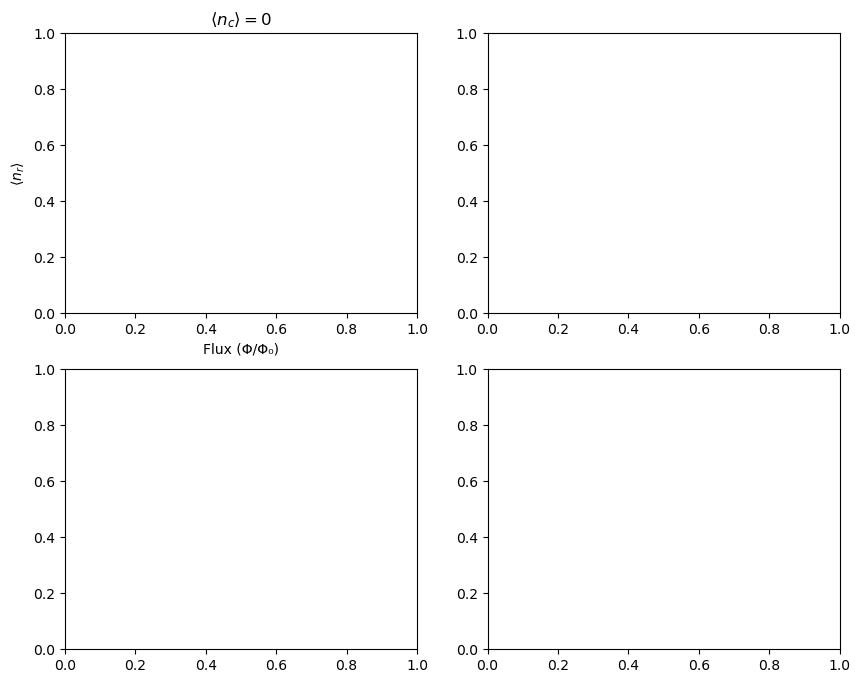

In [11]:
step =.02
flux_arr = np.arange(-.2, .6, step)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 75, 1)
extent = [-.2, .6, n_r_list[0], n_r_list[-1]]

for ax, key, name in zip(axes, key_list1, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(dat1[key].T)

    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=1, vmax=3)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |1⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
#plt.savefig(r'Excited State')
plt.show()

In [19]:
def get_MIST_dens(data, freq_range, n_r, threshold):
    key_list = [key for key in data.keys() if 'n_q' in key]
    for key in key_list:
        if '=q0' in key:
            ref_val = 0
        if '=q1' in key:
            ref_val = 1
        num_peaks, peaks_per, n_crit = peak_detection_2(data, key, ref_val, freq_range, threshold)
        
        tot_key  = key + '_tot'
        dens_key = key + '_dens'
        crit_key = key + '_n_crit'
        dat = data.copy()
        dat[tot_key] = (num_peaks, None, ['n_r'])
        dat[dens_key] = (peaks_per, None, ['n_r'])
        dat[crit_key] = (n_crit, None, ['flux'])
        dat[r'$\langle n_r \rangle$'] = (n_r, None, None) 
    return dat


def peak_detection_2(data, key, ref_val, flux_range, threshold=0.2, cluster_window=5):
      MIST_dat = data[key]
      deriv = np.abs(np.gradient(MIST_dat, axis=1))  # sharp jumps along n_r

      n_flux, n_r_len = MIST_dat.shape
      peaks_vs_nr = np.zeros(n_r_len)
      n_crit = np.full(n_flux, np.nan)  # NaN = no MIST detected

      for flux_idx in range(n_flux):
          row = deriv[flux_idx, :]
          jump_indices = np.where(row > threshold)[0]
          if len(jump_indices) == 0:
              continue

          gaps = np.diff(jump_indices)
          split_points = np.where(gaps > cluster_window)[0] + 1
          clusters = np.split(jump_indices, split_points)

          for cluster in clusters:
              center = cluster[len(cluster) // 2]
              peaks_vs_nr[center] += 1

          n_crit[flux_idx] = clusters[0][0]  # POSITION of first MIST

      density_vs_nr = peaks_vs_nr / flux_range
      return np.cumsum(peaks_vs_nr), density_vs_nr, n_crit

In [12]:
def get_ncrit(data, key, threshold=0.5):
    MIST_dat = data[key]  # (n_flux, n_r)
    ref = MIST_dat[:, 0]  # initial value at n_r=0
    delta = np.abs(MIST_dat - ref[:, np.newaxis])
    
    n_flux = MIST_dat.shape[0]
    n_crit = np.full(n_flux, 40)
    
    for flux_idx in range(n_flux):
      exceeded = np.where(delta[flux_idx, :] > threshold)[0]
      if len(exceeded) > 0:
          n_crit[flux_idx] = exceeded[0]
    
    return n_crit

In [13]:
key_list0 = ['n_q_branch=q0_c0', 'n_q_branch=q0_c1', 'n_q_branch=q0_c2', 'n_q_branch=q0_c3', 'n_q_branch=q0_c4', 'n_q_branch=q0_c5']
key_list1 = ['n_q_branch=q1_c0', 'n_q_branch=q1_c1', 'n_q_branch=q1_c2', 'n_q_branch=q1_c3', 'n_q_branch=q1_c4', 'n_q_branch=q1_c5']

In [18]:
def big_heatmaps(dat_list, key_list):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    name_list = [r'$⟨n_c⟩ = 0$', r'$⟨n_c⟩ = 1$', r'$⟨n_c⟩ = 2$', r'$⟨n_c⟩ = 3$']
    ims = []
    if 'q0' in key_list[0]:
        title = r'$\Psi_{init} = |0⟩$'
        save_name = 'ground_state_crit.jpg'
    else:
        title = r'$\Psi_{init} = |1⟩$'
        save_name = 'excited_state_crit.jpg'
    for ax, key, name in zip(axes, key_list, name_list):
        #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
        ax.set_title(name)
        ax.set_xlabel('Flux (Φ/Φ₀)')
        ax.set_ylabel(r'$E_C^a/E_J^a$')
        crit_list = [get_ncrit(data, key) for data in dat_list]
        
        extent = [0, .5, .01, 1]
        min_len = min(len(c) for c in crit_list)
        crit_arr = np.array([c[:min_len] for c in crit_list])
        im = ax.imshow(crit_arr, aspect='auto', extent=extent, cmap='magma_r')
        ims.append(im)
        ax.set_aspect("auto")
        
    fig.subplots_adjust(left=0.08, right=0.88, wspace=0.2, hspace=0.3)
    cbar_ax = fig.add_axes([0.90, 0.125, 0.02, .75])  # [left, bottom, width, height]
    fig.colorbar(ims[0], cax=cbar_ax, label=r'$\log{n_{crit}}$')
    fig.suptitle(title, fontsize=16)
    plt.savefig(save_name, dpi=200)
    plt.show()

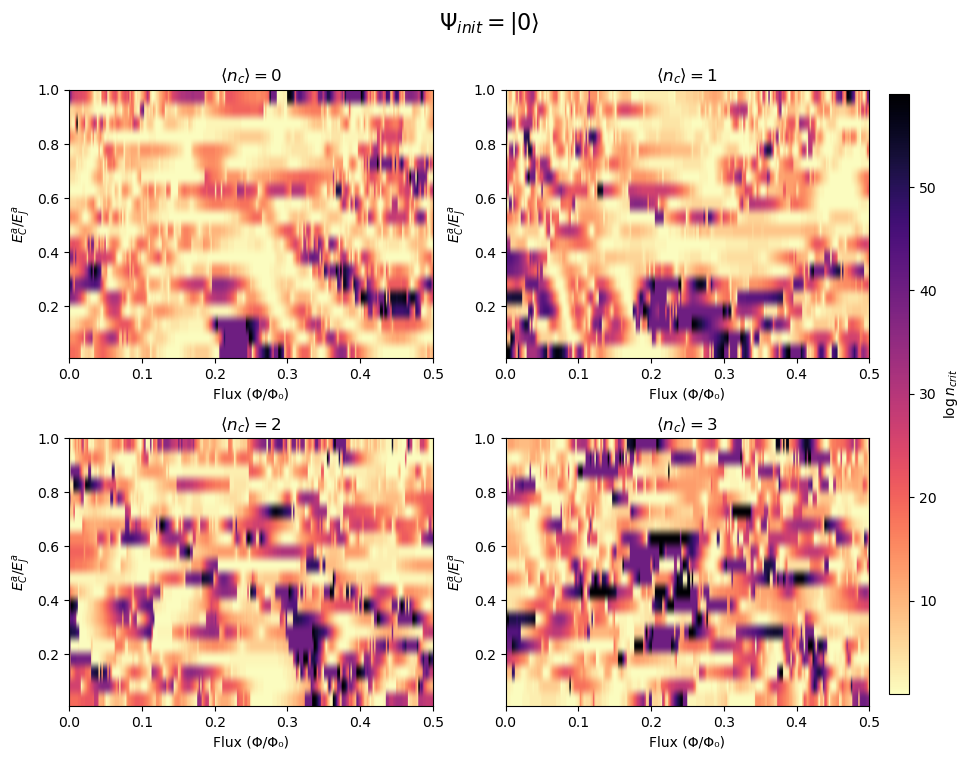

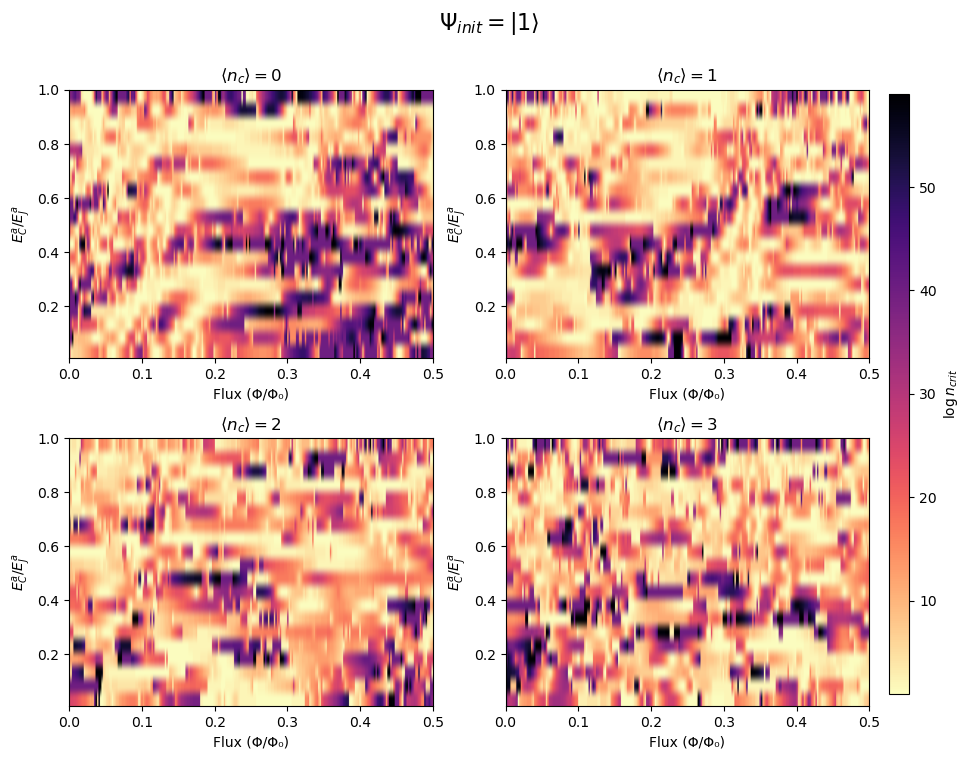

In [19]:
big_heatmaps(dat_list_0, key_list0)
big_heatmaps(dat_list_1, key_list1)

In [154]:
def get_weights(num, omega, temp):
    omega_list = omega * np.arange(1, num+1, 1)
    temp_GHz = temp * 20.83
    propto = np.exp(-omega_list / temp_GHz)
    return propto / np.sum(propto)

In [13]:
weights = get_weights(6, 1.5, .04)

In [14]:
small0 = [key for key in dat0.keys() if ('n_q') in key]
small1 = [key for key in dat1.keys() if ('n_q') in key]

In [15]:
therm0 = sum(weight * dat0[key] for weight, key in zip(weights, small0))  
therm1 = sum(weight * dat1[key] for weight, key in zip(weights, small1))  

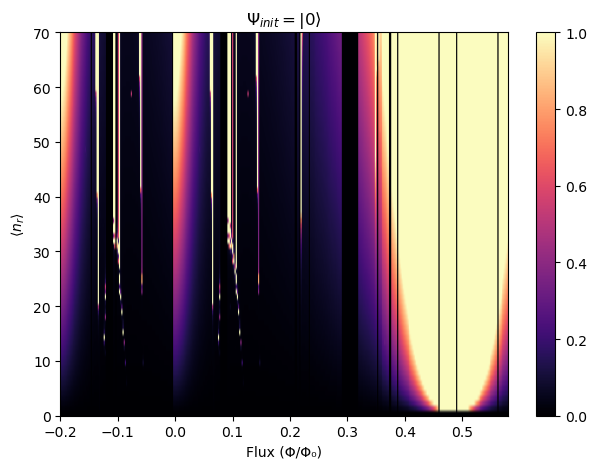

In [16]:
fixed = Z_fixed = np.flipud(therm0.T)
plt.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=1, aspect='auto')
plt.xlabel('Flux (Φ/Φ₀)')
plt.ylabel(r'$⟨n_r⟩$')
plt.ylim(0, 70)
plt.colorbar()
#ax.set_aspect("auto")
plt.title(r'$\Psi_{init} = |0⟩$')
fig.suptitle(title, fontsize=16)
plt.tight_layout()

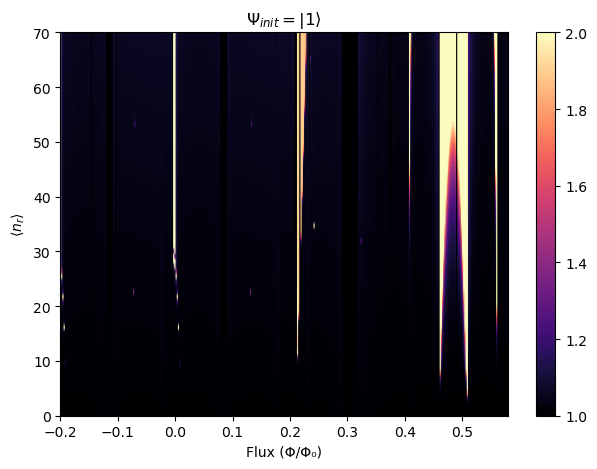

In [17]:
fixed = Z_fixed = np.flipud(therm1.T)
plt.imshow(fixed, extent=extent, cmap='magma', vmin=1, vmax=2, aspect='auto')
plt.xlabel('Flux (Φ/Φ₀)')
plt.ylabel(r'$⟨n_r⟩$')
plt.ylim(0, 70)
plt.colorbar()
#ax.set_aspect("auto")
plt.title(r'$\Psi_{init} = |1⟩$')
fig.suptitle(title, fontsize=16)
plt.tight_layout()